<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.3-million-structures-in-MPF.2021.2.8.all" data-toc-modified-id="1.3-million-structures-in-MPF.2021.2.8.all-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>1.3 million structures in MPF.2021.2.8.all</a></span><ul class="toc-item"><li><span><a href="#load-pre-processed-M3GNet-features-of-the-1.3-million-data-in-MPF.2021.2.8.all" data-toc-modified-id="load-pre-processed-M3GNet-features-of-the-1.3-million-data-in-MPF.2021.2.8.all-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>load pre-processed M3GNet features of the 1.3 million data in MPF.2021.2.8.all</a></span></li><li><span><a href="#DIRECT-sampling" data-toc-modified-id="DIRECT-sampling-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>DIRECT sampling</a></span></li><li><span><a href="#Manual-sampling" data-toc-modified-id="Manual-sampling-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Manual sampling</a></span></li><li><span><a href="#visualizing-the-coverage-of-feature-space" data-toc-modified-id="visualizing-the-coverage-of-feature-space-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>visualizing the coverage of feature space</a></span></li><li><span><a href="#Feature-coverage-score" data-toc-modified-id="Feature-coverage-score-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Feature coverage score</a></span></li></ul></li></ul></div>

In [1]:
from maml.sampling.direct import DIRECTSampler, BirchClustering, SelectKFromClusters
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# 1.3 million structures in MPF.2021.2.8.all

M3GNet feature processing is time consuming for 1.3 million structures, so in this example 1, we have provided the processed M3GNet features. 

## load pre-processed M3GNet features of the 1.3 million data in MPF.2021.2.8.all

The file M3GNet_features_MPF_2021_2_8_All_DFTstrictF10.pickle can be downloaded at: https://figshare.com/articles/dataset/20230723_figshare_DIRECT_zip/23734134

In [2]:
%%time
with open("M3GNet_features_MPF_2021_2_8_All_DFTstrictF10.pickle", "rb") as f:
    MPF_2021_2_8_All_feature_data = pickle.load(f)

CPU times: user 477 ms, sys: 284 ms, total: 761 ms
Wall time: 976 ms


In [3]:
MPF_2021_2_8_All_feature_data['M3GNet_features'].shape, MPF_2021_2_8_All_feature_data.keys()

((1315097, 128), dict_keys(['M3GNet_features', 'relax_label', 'id']))

## DIRECT sampling
Please refer to the DIRECT manuscript about setting n and k values. threshold_init is a parameter of Birch clustering method, which should be tunned to get desired n clusters. Some tunning is already built in, while a meaningful initial guess is needed. The default value of 0.5 is usually a good guess. It needs to be decreased if the number of clusters is below expectation, and vice versa.

In [4]:
%%time
DIRECT_sampler = DIRECTSampler(structure_encoder=None, 
                               clustering=BirchClustering(n=20050, threshold_init=0.15),
                               select_k_from_clusters=SelectKFromClusters(k=20))

CPU times: user 18 µs, sys: 0 ns, total: 18 µs
Wall time: 18.8 µs


In [5]:
%%time
DIRECT_selection = DIRECT_sampler.fit_transform(MPF_2021_2_8_All_feature_data['M3GNet_features'])

Selected first 14 PCs, explaining 92.61% variance
Birch threshold of 0.15 gives 21311 clusters.
Finally selected 185670 configurations.
CPU times: user 5min 20s, sys: 10.8 s, total: 5min 31s
Wall time: 1min 26s


In [6]:
print(f"DIRECT selected {len(DIRECT_selection['selected_indexes'])} structures from {len(DIRECT_selection['PCAfeatures'])} structures in MPF.2021.2.8.All.")

DIRECT selected 185670 structures from 1315097 structures in MPF.2021.2.8.All.


## Manual sampling
First and middle snapshots of the 1st relaxation and last snapshot of the 2nd relaxation was manually selected as training set for M3GNet-v0.1

In [7]:
manual_selection_index = [i for i,l in enumerate(MPF_2021_2_8_All_feature_data['relax_label']) if l]

In [8]:
print(f"Manually selected {len(manual_selection_index)} structures from {len(DIRECT_selection['PCAfeatures'])} structures in MPF.2021.2.8.All.")

Manually selected 185877 structures from 1315097 structures in MPF.2021.2.8.All.


## visualizing the coverage of feature space

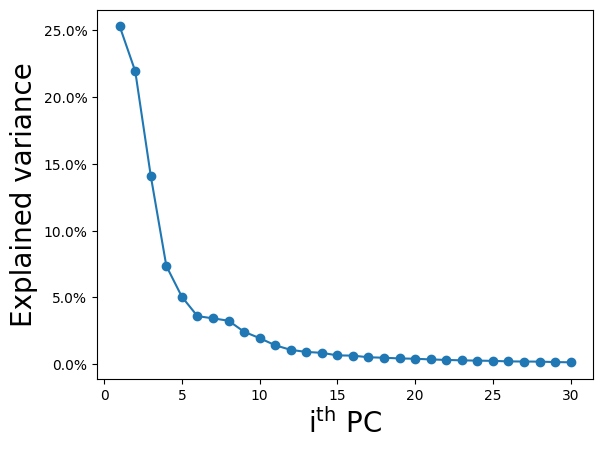

In [9]:
explained_variance = DIRECT_sampler.pca.pca.explained_variance_ratio_
DIRECT_selection['PCAfeatures_unweighted'] = DIRECT_selection['PCAfeatures']/explained_variance[:14]

plt.plot(range(1, 31), explained_variance[:30]*100, "o-",)
plt.xlabel("i$^{\mathrm{th}}$ PC", size=20)
plt.ylabel("Explained variance", size=20)
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [10]:
def plot_PCAfeature_coverage(all_features, selected_indexes, method="DIRECT"):
    fig, ax = plt.subplots(figsize=(5, 5))
    selected_features = all_features[selected_indexes]
    plt.plot(all_features[:, 0], all_features[:, 1], "*",alpha=0.5,
                label=f"All {len(all_features):,} structures")
    plt.plot(selected_features[:, 0], selected_features[:, 1],"*", alpha=0.5,
                label=f"{method} sampled {len(selected_features):,}")
    legend = plt.legend(frameon=False, fontsize=14, loc='upper left', bbox_to_anchor=(-0.02,1.02), reverse=True)
    for lh in legend.legendHandles: 
        lh.set_alpha(1)
    plt.ylabel("PC 2", size=20)
    plt.xlabel("PC 1", size=20)
    plt.yscale("symlog")
    plt.xscale("symlog")

/var/folders/rr/d33n0r7d06zc3bfdcz58s0w00000gn/T/ipykernel_53920/1654159683.py:9: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


CPU times: user 188 ms, sys: 15.7 ms, total: 203 ms
Wall time: 69.1 ms


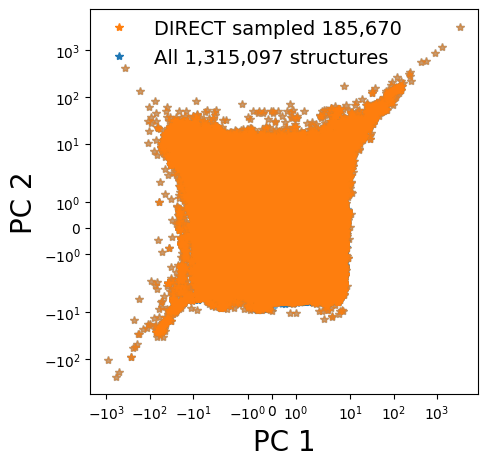

In [11]:
%%time
all_features = DIRECT_selection['PCAfeatures_unweighted']
selected_indexes = DIRECT_selection['selected_indexes']
plot_PCAfeature_coverage(all_features, selected_indexes)


/var/folders/rr/d33n0r7d06zc3bfdcz58s0w00000gn/T/ipykernel_53920/1654159683.py:9: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


CPU times: user 46.3 ms, sys: 9.54 ms, total: 55.8 ms
Wall time: 54 ms


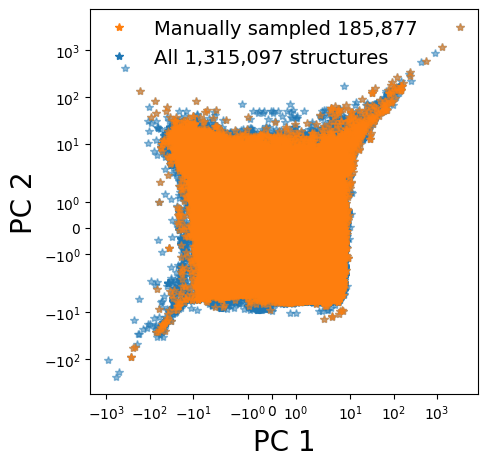

In [12]:
%%time
plot_PCAfeature_coverage(all_features, manual_selection_index, "Manually")

## Feature coverage score

In [13]:
def calculate_feature_coverage_score(all_features, selected_indexes, n_bins=100):
    selected_features = all_features[selected_indexes]
    n_all = np.count_nonzero(np.histogram(all_features, bins=np.linspace(min(all_features), max(all_features), n_bins))[0])
    n_select = np.count_nonzero(np.histogram(selected_features, bins=np.linspace(min(all_features), max(all_features), n_bins))[0])
    return n_select/n_all

In [14]:
def calculate_all_FCS(all_features, selected_indexes, b_bins=100):
    select_scores = [calculate_feature_coverage_score(all_features[:, i], selected_indexes, n_bins=b_bins) \
                     for i in range(all_features.shape[1])]
    return select_scores

In [15]:
%%time
all_features = DIRECT_selection['PCAfeatures_unweighted']
scores_MPF_DIRECT = calculate_all_FCS(all_features, DIRECT_selection['selected_indexes'], b_bins=50000)
scores_MPF_MS = calculate_all_FCS(all_features, manual_selection_index, b_bins=50000)

CPU times: user 6.89 s, sys: 46.6 ms, total: 6.94 s
Wall time: 6.96 s


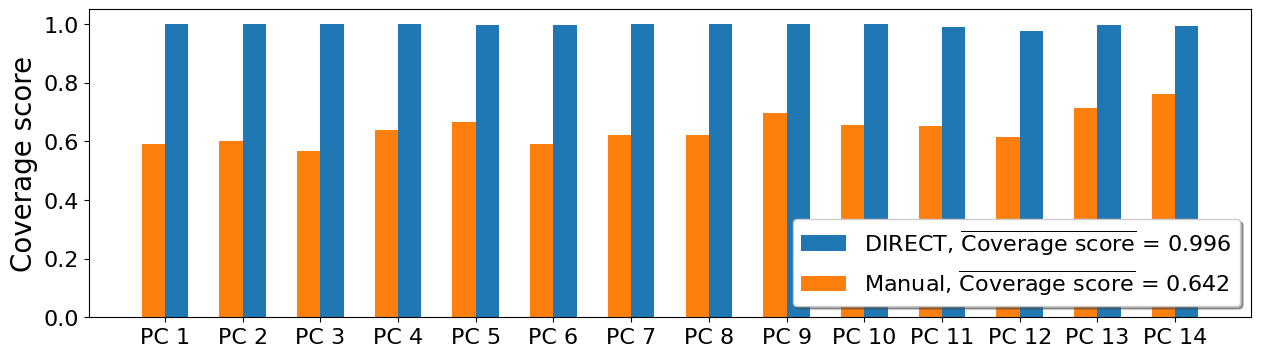

In [16]:
x = np.arange(len(scores_MPF_DIRECT))
x_ticks = [f"PC {n+1}" for n in range(len(x))]

plt.figure(figsize=(15,4))
plt.bar(x+0.6, scores_MPF_DIRECT, width=0.3, label=f"DIRECT, $\overline{{\mathrm{{Coverage\ score}}}}$ = {np.mean(scores_MPF_DIRECT):.3f}")
plt.bar(x+0.3, scores_MPF_MS, width=0.3, label=f"Manual, $\overline{{\mathrm{{Coverage\ score}}}}$ = {np.mean(scores_MPF_MS):.3f}")
plt.xticks(x+0.45, x_ticks,size=16)
plt.yticks(np.linspace(0,1.,6),size=16)
plt.ylabel("Coverage score", size=20)
plt.legend(shadow=True, loc="lower right", fontsize=16)